### Exercise: using PyTorch to train a small neural network to do MNIST classification. Goal: ~99% test accuracy using a 3-layer convolutional neural network.

In [1]:
import torch
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import torchvision.transforms as tfms
from torch.optim import Adam, SGD
import torch.nn as nn
import torch.nn.functional as F

#### Get training data & show a few example images

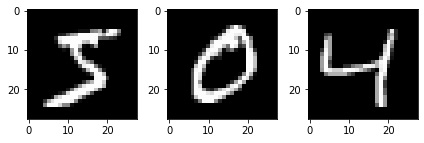

In [2]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=tfms.ToTensor())
testset = datasets.MNIST(root='./data', train=False, download=True, transform=tfms.ToTensor())

fig, axes = plt.subplots(1, 3)
for i in range(3):
    x, _ = mnist_trainset[i]
    ax = axes[i]
    ax.imshow(x.numpy()[0], cmap='gray')
plt.tight_layout()
plt.show()

In [3]:
x.shape

torch.Size([1, 28, 28])

#### Set up model

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320) # flatten
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

#### Train

In [5]:
# batch_size = 128
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
# momentum = 0.5
# log_interval = 10
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [6]:
model = Net()
optimizer = SGD(model.parameters(), lr=0.07)#,momentum=momentum)

# defining the loss function
criterion = nn.CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [7]:
train_losses = []
train_counter = []
test_losses = []
# test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(mnist_trainset): # enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(mnist_trainset),100. * batch_idx / len(mnist_trainset), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(mnist_dataset)))
            #torch.save(network.state_dict(), '/results/model.pth')
            #torch.save(optimizer.state_dict(), '/results/optimizer.pth')

### Test

In [11]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in enumerate(mnist_trainset):
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
        test_loss /= len(testset)
        test_losses.append(test_loss)
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(testset),100. * correct / len(testset)))

### Execute

In [12]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

TypeError: conv2d() received an invalid combination of arguments - got (int, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: ([31;1mint[0m, [31;1mParameter[0m, [31;1mParameter[0m, [31;1mtuple[0m, [31;1mtuple[0m, [31;1mtuple[0m, [32;1mint[0m)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: ([31;1mint[0m, [31;1mParameter[0m, [31;1mParameter[0m, [31;1mtuple[0m, [31;1mtuple[0m, [31;1mtuple[0m, [32;1mint[0m)
